# Mental Health: Is it still a Taboo? | Insights from the Tech Industry

&nbsp;

## 1. Introduction
Did you know that **1 in every 8 people in the world live with a mental disorder**, as of 2022? And that **most do not have access to proper care**, even though effective prevention and treatment options do exist [[World Health Organization]](https://www.who.int/news-room/fact-sheets/detail/mental-disorders)?

There is a wide range of mental disorders, going from the common depressions and anxieties to schizophrenias, not forgetting personality disorders and so forth. These mental conditions can be properly tackled if awareness to them is present, and the proper conditions for prevention and treatment are met. If so, people suffering, or susceptible to suffer, from a mental health disorder can have a better quality of life, and consequently see their productivity improved. As such, it is important for these people (and everyone around them) to have the **proper awareness** level and the **means for prevention and treatment** in all spheres of their lives, including at the workplace (since it is there that individuals spend a large amount of their lifetime).

Hence, an interesting question arises: **How exactly does the workplace fare on these issues?**

&nbsp;

### 1.1. Objectives
The intent with this project is to draw insights from the technology industry, considering the period from 2014 to 2019, on the level of awareness of mental health disorders, and how these are handled in a working environment context. However, having these evaluations done, the real endgoal is to **provide solutions for a healthier and more sustainable workplace** on a mental health perspective.

&nbsp;

### 1.2. Source of the Data
The datasets used for this project were retrieved from [Kaggle](https://www.kaggle.com/datasets/anth7310/mental-health-in-the-tech-industry/data). However, the primary source of the data was [Open Sourcing Mental Illness (OSMI)](https://osmihelp.org).

&nbsp;

### 1.3. Datasets Description
The SQLite database contains 3 tables: **Survey**, **Question**, and **Answer**.

* Survey (PRIMARY KEY INT SurveyID, TEXT Description)
* Question (PRIMARY KEY QuestionID, TEXT QuestionText)
* Answer (PRIMARY/FOREIGN KEY SurveyID, PRIMARY KEY UserID, PRIMARY/FOREIGN KEY QuestionID, TEXT AnswerText)

SurveyID are simply survey years i.e. 2014, 2016, 2017, 2018, 2019.
The same question can be used for multiple surveys.
Answer table is a composite table with multiple primary keys. SurveyID and QuestionID are FOREIGN KEYS.
Some questions can contain multiple answers, thus the same UserID can appear more than once for a particular QuestionID.

&nbsp;

## 2. Setting Up for Data Analysis
### 2.1. Importing Libraries and Loading Data

In [290]:
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns

sns.axes_style("white")


database_path = "./mental_health.sqlite"
con = sql.connect(database_path)

In [291]:
tables = pd.read_sql(
    """
    SELECT sql FROM sqlite_master 
    WHERE TYPE = 'table'
    """,
    con,
)

for row in tables["sql"]:
    print(row)

CREATE TABLE "Answer" (
	"AnswerText" VARCHAR(10000) NULL,
	"SurveyID" INTEGER NULL,
	"UserID" INTEGER NULL,
	"QuestionID" INTEGER NULL
)
CREATE TABLE "Question" (
	"questiontext" VARCHAR(1000) NULL,
	"questionid" INTEGER NULL
)
CREATE TABLE "Survey" (
	"SurveyID" INTEGER NOT NULL,
	"Description" VARCHAR(255) NULL,
	PRIMARY KEY ("SurveyID")
)


In [292]:
survey = pd.read_sql("""SELECT * FROM survey""", con)
question = pd.read_sql("""SELECT * FROM question""", con)
answer = pd.read_sql("""SELECT * FROM answer""", con)

In [293]:
print(f"Survey table shape: {survey.shape}")
survey

Survey table shape: (5, 2)


,SurveyID,Description
0,2014,mental health survey for 2014
1,2016,mental health survey for 2016
2,2017,mental health survey for 2017
3,2018,mental health survey for 2018
4,2019,mental health survey for 2019


In [294]:
print(f"Question table shape: {question.shape}")
question.head()

Question table shape: (105, 2)


,questiontext,questionid
0,What is your age?,1
1,What is your gender?,2
2,What country do you live in?,3
3,"If you live in the United States, which state ...",4
4,Are you self-employed?,5


In [295]:
print(f"Answer table shape: {answer.shape}")
answer.head()

Answer table shape: (236898, 4)


,AnswerText,SurveyID,UserID,QuestionID
0,37,2014,1,1
1,44,2014,2,1
2,32,2014,3,1
3,31,2014,4,1
4,31,2014,5,1


&nbsp;

### 2.2. Data Cleaning
***Note**: Since the 'Survey' table is very short, only descriptive, and does not yield any useful information for the exploratory data analysis, it will not be subjected to data cleaning.*

&nbsp;

#### 2.2.1. Striping Out Whitespaces from String Data Types

In [296]:
cur = con.cursor()

cur.execute("""
    UPDATE question
    SET questiontext = TRIM(questiontext)
    """)

cur.execute("""
    UPDATE answer
    SET answertext = TRIM(answertext)
    """)

con.commit()

&nbsp;

#### 2.2.2. Data Type Parsings/Conversions

All tables already have adequate data types for each of their columns.

&nbsp;

#### 2.2.3. Duplicates

In [297]:
pd.read_sql(
    """
    SELECT COUNT(*) nr_questions,
        COUNT(DISTINCT questiontext) nr_dif_questiontexts
    FROM question
    """,
    con,
)

,nr_questions,nr_dif_questiontexts
0,105,105


No questions are duplicated in the 'question' table.

In [298]:
pd.read_sql(
    """
    SELECT COUNT(DISTINCT surveyid) nr_surveys,
        COUNT(DISTINCT questionid) nr_questions,
        COUNT(DISTINCT userid) nr_users
    FROM answer
    """,
    con,
)

,nr_surveys,nr_questions,nr_users
0,5,105,4218


Regarding the 'answer' table, the number of distinct surveys is the expected one (5), and the number of distinct question ID's matches the number of questions on the 'question' table.

As additional information, we have 4218 different people surveyed from 2014 to 2019.

In [299]:
pd.read_sql(
    """
    SELECT DISTINCT questionid
    FROM answer
    GROUP BY surveyid, userid, questionid
    HAVING COUNT(*) > 1
    ORDER BY 1
    """,
    con,
    index_col="QuestionID",
)

""
QuestionID
115
116
117


It seems there are questions answered more than once by the same user on the same survey, namely questions with ID 115, 116, and 117. Let's have a look at their content.

In [300]:
mul_ans_questions = pd.read_sql(
    """
    SELECT questiontext
    FROM question
    WHERE questionid IN (115, 116, 117)
    """,
    con,
)

for mul_ans_question in mul_ans_questions["questiontext"]:
    print(mul_ans_question)

If yes, what condition(s) have you been diagnosed with?
If maybe, what condition(s) do you believe you have?
Which of the following best describes your work position?


By reading these questions, one can understand that multiple answers would be accepted for each.

In [301]:
pd.read_sql(
    """
    SELECT userid, COUNT(DISTINCT surveyid) survey_count
    FROM answer
    GROUP BY userid
    HAVING survey_count > 1
    """,
    con,
)

,UserID,survey_count


No user has participated in more than one survey. Therefore, we will not have data from the same person in different years.

In [302]:
pd.read_sql(
    """
    SELECT questionid, COUNT(DISTINCT surveyid) Survey_count
    FROM answer
    GROUP BY questionid
    ORDER BY questionid
    """,
    con,
    index_col="QuestionID",
)

,Survey_count
QuestionID,
1,5
2,5
3,5
4,5
5,5
...,...
114,1
115,1
116,1


From here, we can see that some questions were repeated over the years, while others were only featured in a single survey.

Moreover, if we look closely, there are 118 questionID's and only 105 rows in this table, suggesting that we are missing some questionID's. This could be due to some questions having been erased in the past, or simply not having made it to feature in any of the surveys.

&nbsp;

#### 2.2.4. Missing Values

In [303]:
pd.read_sql(
    """
    SELECT *
    FROM question
    WHERE questionid IS NULL
        OR questiontext IS NULL
        OR questiontext = ''
        OR questiontext = -1
    """,
    con,
)

,questiontext,questionid


No missing values in the 'question' table.

In [304]:
pd.read_sql(
    """
    SELECT *
    FROM answer
    WHERE answertext IS NULL
        OR answertext = ''
        OR surveyid IS NULL
        OR questionid IS NULL
        OR userid IS NULL
    """,
    con,
)

,AnswerText,SurveyID,UserID,QuestionID


In [305]:
pd.read_sql(
    """
    SELECT questionid, COUNT(*) nr_unknown_answers
    FROM answer
    WHERE answertext = -1
    GROUP BY questionid
    """,
    con,
    index_col="QuestionID",
)

,nr_unknown_answers
QuestionID,
1,5
2,24
3,2
4,1622
5,18
...,...
110,169
111,169
112,169


It seems we have quite a few '-1' answers in the AnswerText column, throughout 82 different questions. Since no answer of '-1' would be acceptable for any of the questions (considering that for some questions a negative answer is represented by 0 and not by -1), we can assume that the -1 input was, for whoever inserted the data, their version of a NULL value.

As such, and considering the large amount of data present in this dataset, all -1 (NULL) values will be simply discarded for the data analysis.

In [306]:
cur.execute("""
    DELETE FROM answer
    WHERE answertext = -1
    """)

con.commit()

In [307]:
answer = pd.read_sql("""SELECT * FROM answer""", con)
print(f"Answer table new shape: {answer.shape}")

Answer table new shape: (180300, 4)


&nbsp;

#### 2.2.5. Outliers

In [308]:
pd.read_sql(
    """
    SELECT MIN(questionid) min_questionid, MAX(questionid) max_questionid
    FROM question
    """,
    con,
)

,min_questionid,max_questionid
0,1,118


In [309]:
pd.read_sql(
    """
    SELECT MIN(surveyid) min_surveyid,
        MAX(surveyid) max_surveyid,
        MIN(questionid) min_questionid,
        MAX(questionid) max_questionid,
        MIN(userid) min_userid,
        MAX(userid) max_userid
    FROM answer
    """,
    con,
)

,min_surveyid,max_surveyid,min_questionid,max_questionid,min_userid,max_userid
0,2014,2019,1,118,1,4218


No ID's outside of their range of values found in both tables. Nice!

&nbsp;

## 3. Data Analysis

The present data analysis will take into consideration all available surveys from the different years without making any distinction between the years, so as to get the most data as possible and obtain robust conclusions.

Furthermore, questions regarding exclusively previous employers/workplaces will not be studied, as these do not reflect the most recent situation in the tech industry, and some of those previous companies could have even already gotten out of business.

In order to plan our data analysis, it is a good idea to roll out the content of all the different questions present in the surveys. Here they are:

In [310]:
for row in question[["questionid", "questiontext"]].itertuples(index=False):
    print(f"{row.questionid}. {row.questiontext}")

1. What is your age?
2. What is your gender?
3. What country do you live in?
4. If you live in the United States, which state or territory do you live in?
5. Are you self-employed?
6. Do you have a family history of mental illness?
7. Have you ever sought treatment for a mental health disorder from a mental health professional?
8. How many employees does your company or organization have?
9. Is your employer primarily a tech company/organization?
10. Does your employer provide mental health benefits as part of healthcare coverage?
11. Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
12. Would you bring up a mental health issue with a potential employer in an interview?
13. Is your primary role within your company related to tech/IT?
14. Do you know the options for mental health care available under your employer-provided health coverage?
15. Has your employer ever formally discussed mental hea

### 3.1. Sample Demographic Description
*What are the demographic characteristics of our sample?*

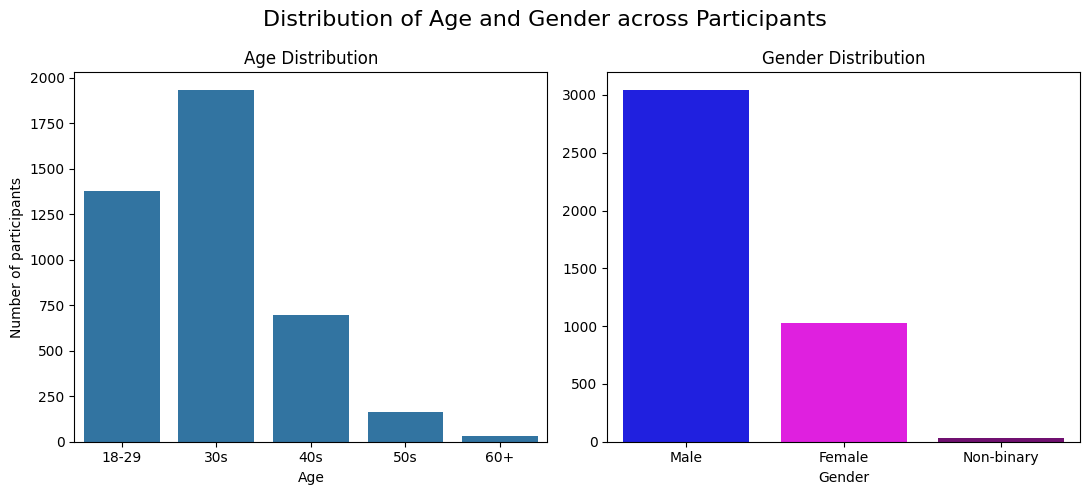

In [311]:
age = pd.read_sql(
    """
    SELECT
        CASE WHEN AnswerText BETWEEN 18 AND 29 THEN '18-29'
            WHEN AnswerText BETWEEN 30 AND 39 THEN '30s'
            WHEN AnswerText BETWEEN 40 AND 49 THEN '40s'
            WHEN AnswerText BETWEEN 50 AND 59 THEN '50s'
            WHEN AnswerText >= 60 THEN '60+'
            END Age,
        COUNT(*) 'Number of participants'
    FROM answer
    WHERE questionid = 1
        AND AnswerText >= 18
        AND AnswerText < 99
    GROUP BY Age
    ORDER BY Age
    """,
    con,
)

gender = pd.read_sql(
    """
    SELECT
        CASE WHEN AnswerText LIKE 'male' THEN 'Male'
            WHEN AnswerText LIKE 'female' THEN 'Female'
            WHEN AnswerText LIKE 'nonbinary'
                OR AnswerText LIKE 'non-binary'
                OR AnswerText LIKE 'non binary'
                OR AnswerText LIKE 'agender'
                OR AnswerText LIKE 'genderqueer'
                OR AnswerText LIKE 'genderfluid' THEN 'Non-binary'
            END Gender,
        COUNT(*) 'Number of participants'
    FROM answer
    WHERE (questionid = 2)
        AND (answertext LIKE 'female'
        OR answertext LIKE 'male'
        OR answertext LIKE 'nonbinary'
        OR answertext LIKE 'non-binary'
        OR answertext LIKE 'non binary'
        OR answertext LIKE 'agender'
        OR answertext LIKE 'genderqueer'
        OR answertext LIKE 'genderfluid')
    GROUP BY Gender
    """,
    con,
)


fig, axes = plt.subplots(1, 2, figsize=(11, 5))

fig.suptitle(
    "Distribution of Age and Gender across Participants",
    fontsize=16,
)

sns.barplot(age, x="Age", y="Number of participants", ax=axes[0])
sns.barplot(
    gender,
    x="Gender",
    y="Number of participants",
    hue="Gender",
    order=["Male", "Female", "Non-binary"],
    hue_order=["Male", "Female", "Non-binary"],
    palette=sns.color_palette(["blue", "magenta", "purple"]),
    ax=axes[1],
)

axes[0].set_title("Age Distribution")

axes[1].set_title("Gender Distribution")
axes[1].set_ylabel("")

plt.tight_layout()

* **The big majority of participants was young (< 40 years-old) and male.**

    >Due to the boom of the tech industry in recent years, the younger generations became more attracted to work in this field. Moreover, it might also be the case that younger people are more prone to complete a survey than older people.
    
    >However, there is still a very large discrepancy between the number of males and females in the tech industry.

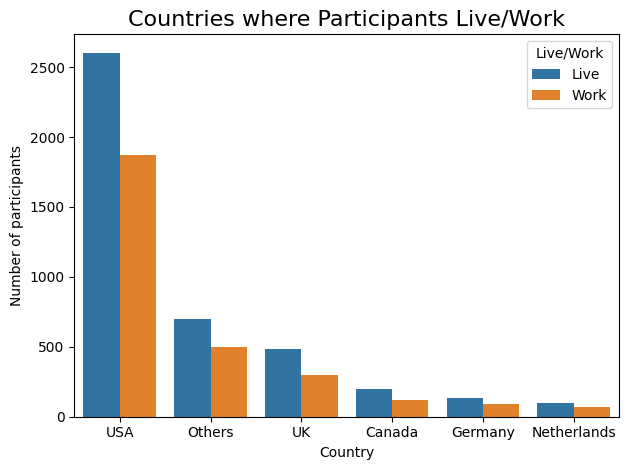

In [312]:
country = pd.read_sql(
    """
    SELECT
        CASE WHEN AnswerText = 'United States'
                OR AnswerText = 'United States of America' THEN 'USA'
            WHEN AnswerText = 'United Kingdom' THEN 'UK'
            WHEN AnswerText IN ('Canada', 'Germany', 'Netherlands') THEN AnswerText
            ELSE 'Others'
            END Country,
        COUNT(*) 'Number of participants',
        CASE WHEN questionid = 3 THEN 'Live'
            ELSE 'Work'
            END 'Live/Work'
    FROM answer
    WHERE questionid IN (3, 50)
    GROUP BY questionid, Country
    ORDER BY 2 DESC
    """,
    con,
)


sns.barplot(country, x="Country", y="Number of participants", hue="Live/Work")

plt.title("Countries where Participants Live/Work", fontsize=16)
plt.tight_layout()

* **Most participants were living and working in the United States of America, followed by the United Kingdom and Canada.**

    >The surveys were very likely organized in the USA, and the fact that there is a consistent lower number of participants in the 'Work' country bars is due to the fact that the respective question only featured in the surveys starting from 2016.

&nbsp;

### 3.2. Mental Health Disorders
*What was the prevalence of mental health disorders? Which were the most common?*

*To which extent did these conditions impact the work productivity?*

*Were there any differences in the presence of these conditions across the different age and gender groups?*

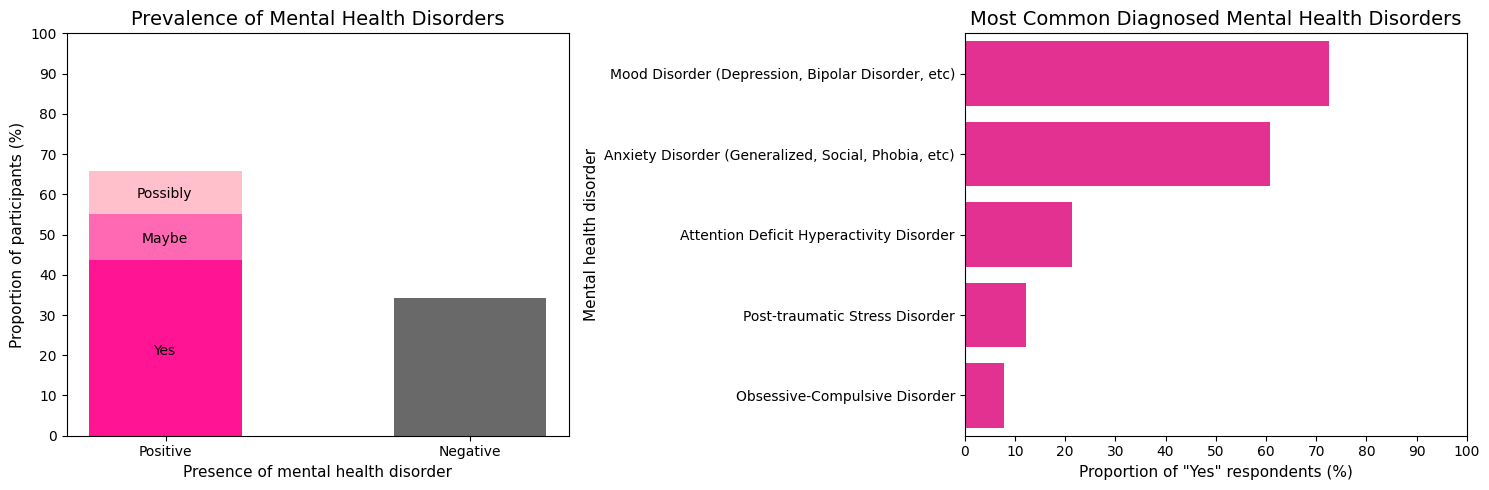

In [313]:
mhd_prevalence = pd.read_sql(
    """
    WITH mhd_counts AS (
        SELECT answertext presence_mhd,
            COUNT(*) count
        FROM answer
        WHERE questionid = 33
            AND answertext <> 'Don''t Know'
        GROUP BY 1
    )
    SELECT presence_mhd,
        count * 100.0 / (SELECT SUM(count) FROM mhd_counts) 'proportion'
    FROM mhd_counts
    ORDER BY 2 DESC
    """,
    con,
)

x = ["Positive", "Negative"]
y_yes = np.array([mhd_prevalence.iloc[0, 1], 0])
y_no = np.array([0, mhd_prevalence.iloc[1, 1]])
y_maybe = np.array([mhd_prevalence.iloc[2, 1], 0])
y_possibly = np.array([mhd_prevalence.iloc[3, 1], 0])


mhd_diagnosed = pd.read_sql(
    """
    WITH mhd_diagnosis AS (
        SELECT answertext mhd, COUNT(*) c
        FROM answer
        WHERE questionid = 115
        GROUP BY answertext
        ORDER BY c DESC
        LIMIT 5
    ),
    mhd_yes_counts AS (
        SELECT COUNT(DISTINCT userid) yes_counts
        FROM answer
        WHERE questionid = 115
    )
    SELECT mhd,
        c * 100.0 / (SELECT yes_counts FROM mhd_yes_counts) proportion
    FROM mhd_diagnosis
    """,
    con,
)


fig, axes = plt.subplots(1, 2, figsize=(15, 5))


axes[0].bar(x, height=y_yes, color="deeppink", width=0.5)
axes[0].bar(x, height=y_maybe, bottom=y_yes, color="hotpink", width=0.5)
axes[0].bar(x, height=y_possibly, bottom=y_yes + y_maybe, color="pink", width=0.5)
axes[0].bar(
    x, height=y_no, bottom=y_yes + y_maybe + y_possibly, color="dimgray", width=0.5
)

sns.barplot(mhd_diagnosed, x="proportion", y="mhd", color="deeppink", ax=axes[1])


axes[0].set_title("Prevalence of Mental Health Disorders", fontsize=14)
axes[0].annotate("Yes", (-0.04, 20))
axes[0].annotate("Maybe", (-0.08, 48))
axes[0].annotate("Possibly", (-0.095, 59))
axes[0].set_ylim([0, 100])
axes[0].yaxis.set_major_locator(MultipleLocator(10))
axes[0].set_ylabel("Proportion of participants (%)", fontsize=11)
axes[0].set_xlabel("Presence of mental health disorder", fontsize=11)

axes[1].set_title("Most Common Diagnosed Mental Health Disorders", fontsize=14)
axes[1].set_ylabel("Mental health disorder", fontsize=11)
axes[1].xaxis.set_major_locator(MultipleLocator(10))
axes[1].set_xlabel('Proportion of "Yes" respondents (%)', fontsize=11)
axes[1].set_xlim(0, 100)

plt.tight_layout()

* **The prevalence of a confirmed mental health disorder is just above 40%. However, when including the 'Maybe' and 'Possibly' cases, the prevalence goes up to around 65%, almost double the proportion of negative cases.**

    >This comes to show the large presence of mental disorders in the tech industry, which should therefore not be ignored.

&nbsp;

* **The most common diagnosed mental health disorders were related to mood (>70%) and anxiety disorders (~60%), followed by ADHD (>20%), PTSD (>10%) and OCD (~8%).**

    >The mood and anxiety disorders being the ones with the highest prevalence is in accordance with the general population. Such finding reveals that a special focus when addressing mental problems should be given to these, but of course without forgetting about the other disorders which also achieved a considerable prevalence.

    >Furthermore, the fact that the sum of all the disorders prevalences is above 100% tells us that an individual can be living with more than one disorder at the same time, something not uncommon at all.

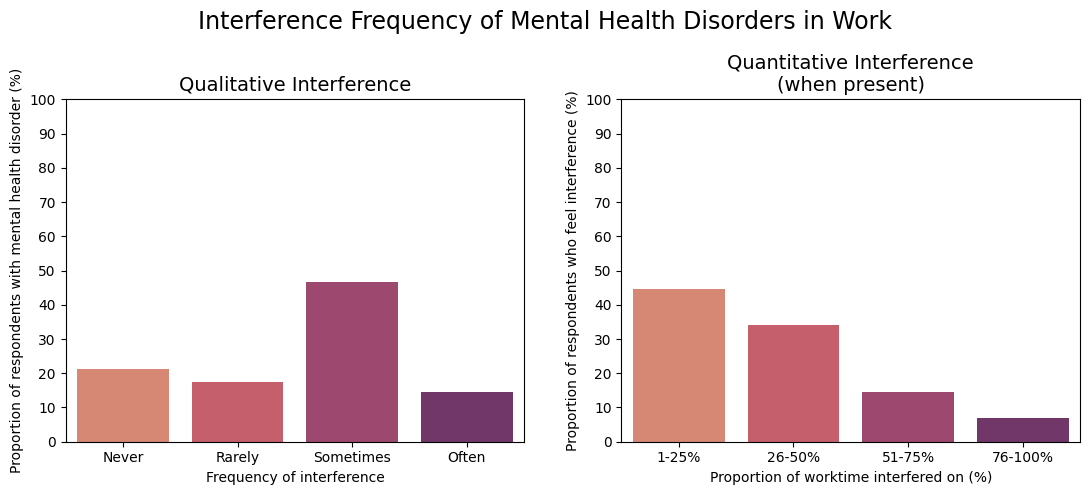

In [314]:
mhd_interf = pd.read_sql(
    """
    WITH mhd_interf_counts AS (
        SELECT answertext, COUNT(*) c
        FROM answer
        WHERE questionid = 92
        GROUP BY answertext
    )
    SELECT answertext freq_interf,
        c * 100.0 / (SELECT SUM(c) FROM mhd_interf_counts) proportion
    FROM mhd_interf_counts
    """,
    con,
)

mhd_interf_time = pd.read_sql(
    """
    WITH mhd_interf_time_counts AS (
        SELECT answertext, COUNT(*) c
        FROM answer
        WHERE questionid = 55
        GROUP BY answertext
    )
    SELECT answertext time_perc,
        c * 100.0 / (SELECT SUM(c) FROM mhd_interf_time_counts) proportion
    FROM mhd_interf_time_counts
    """,
    con,
)


fig, axes = plt.subplots(1, 2, figsize=(11, 5))
fig.suptitle("Interference Frequency of Mental Health Disorders in Work", fontsize=17)

sns.barplot(
    mhd_interf,
    x="freq_interf",
    y="proportion",
    hue="freq_interf",
    order=["Never", "Rarely", "Sometimes", "Often"],
    hue_order=["Never", "Rarely", "Sometimes", "Often"],
    palette="flare",
    ax=axes[0],
)
sns.barplot(
    mhd_interf_time,
    x="time_perc",
    y="proportion",
    hue="time_perc",
    palette="flare",
    ax=axes[1],
)

axes[0].set_title("Qualitative Interference", fontsize=14)
axes[0].set_ylabel("Proportion of respondents with mental health disorder (%)")
axes[0].set_ylim(0, 100)
axes[0].yaxis.set_major_locator(MultipleLocator(10))
axes[0].set_xlabel("Frequency of interference")

axes[1].set_title("Quantitative Interference\n(when present)", fontsize=14)
axes[1].set_ylabel("Proportion of respondents who feel interference (%)")
axes[1].set_ylim(0, 100)
axes[1].yaxis.set_major_locator(MultipleLocator(10))
axes[1].set_xlabel("Proportion of worktime interfered on (%)")

plt.tight_layout(w_pad=3)

* **Qualitatively speaking, "sometimes" was the most answered frequency of interference, answer given by almost half of the participants with a mental health disorder. However, when considering any frequency of suffered interference, that proportion goes up to about 80%.**

* **Quantitavely speaking, and only within those who did feel interference at any given frequency, more than half (approximately 55%) answered that more than 25% of their worktime is affected by their mental health disorder.**

    >The importance of addressing mental health issues, especially for employers, at the workplace is clearly shown here with this data. Employers would benefit greatly from helping their employees overcome their mental struggles, as productivity could potentially greatly increase.

In [315]:
mhd_mhs_diff = pd.read_sql(
    """
    WITH id AS (
        SELECT userid id
        FROM answer
    ),
    age AS (
        SELECT
            CASE WHEN CAST(answertext AS INTEGER) BETWEEN 18 AND 29 THEN '18-29'
                WHEN CAST(answertext AS INTEGER) BETWEEN 30 AND 39 THEN '30s'
                WHEN CAST(answertext AS INTEGER) BETWEEN 40 AND 49 THEN '40s'
                WHEN CAST(answertext AS INTEGER) BETWEEN 50 AND 59 THEN '50s'
                WHEN CAST(answertext AS INTEGER) >= 60 THEN '60+'
                END age,
            userid id
        FROM answer
        WHERE questionid = 1
            AND CAST(answertext AS INTEGER) >= 18
            AND CAST(answertext AS INTEGER) < 99
    ),
    gender AS (
        SELECT
            CASE WHEN AnswerText LIKE 'male' THEN 'Male'
                WHEN AnswerText LIKE 'female' THEN 'Female'
                WHEN AnswerText LIKE 'nonbinary'
                    OR AnswerText LIKE 'non-binary'
                    OR AnswerText LIKE 'non binary'
                    OR AnswerText LIKE 'agender'
                    OR AnswerText LIKE 'genderqueer'
                    OR AnswerText LIKE 'genderfluid' THEN 'Non-binary'
                END gender,
            userid id
        FROM answer
        WHERE (questionid = 2)
            AND (answertext LIKE 'female'
            OR answertext LIKE 'male'
            OR answertext LIKE 'nonbinary'
            OR answertext LIKE 'non-binary'
            OR answertext LIKE 'non binary'
            OR answertext LIKE 'agender'
            OR answertext LIKE 'genderqueer'
            OR answertext LIKE 'genderfluid')
    ),
    mhd AS (
        SELECT
            CASE WHEN answertext = 'Maybe' THEN 'Yes'
                WHEN answertext = 'Possibly' THEN 'Yes'
                ELSE answertext
                END mhd,
            userid id
        FROM answer
        WHERE questionid = 33
            AND answertext <> "Don't Know"
    ),
    resources AS (
        SELECT 
            CASE WHEN answertext = "I don't know" THEN "Don't know"
                ELSE answertext
                END resources,
            userid id
        FROM answer
        WHERE questionid = 16
            OR questionid = 96
    ),
    benefits AS (
        SELECT 
            CASE WHEN answertext = "I don't know" THEN "Don't know"
                ELSE answertext
                END benefits,
            userid id
        FROM answer
        WHERE questionid = 10
            AND answertext <> "Not eligible for coverage / NA"
    ),
    comfort AS (
        SELECT 
            CASE WHEN answertext = "Some of them" THEN "Yes"
                ELSE answertext
                END comfort,
            userid id
        FROM answer
        WHERE (questionid = 19 OR questionid = 100)
            AND answertext <> "Maybe"
    ),
    bad_supp AS (
        SELECT answertext bad_supp, userid id
        FROM answer
        WHERE questionid = 56
            AND answertext <> "I've always been self-employed"
            AND answertext <> "Maybe/Not sure"
    ),
    good_supp AS (
        SELECT answertext good_supp, userid id
        FROM answer
        WHERE questionid = 83
            AND answertext <> "I've always been self-employed"
            AND answertext <> "Maybe/Not sure"
    )
    SELECT id.id, age.age, gender.gender, mhd.mhd, resources.resources,
        benefits.benefits, comfort.comfort, bad_supp.bad_supp,
        good_supp.good_supp
    FROM id
    FULL OUTER JOIN age
    ON id.id = age.id
    FULL OUTER JOIN gender
    ON id.id = gender.id
    FULL OUTER JOIN mhd
    ON id.id = mhd.id
    FULL OUTER JOIN resources
    ON id.id = resources.id
    FULL OUTER JOIN benefits
    ON id.id = benefits.id
    FULL OUTER JOIN comfort
    ON id.id = comfort.id
    FULL OUTER JOIN bad_supp
    ON id.id = bad_supp.id
    FULL OUTER JOIN good_supp
    ON id.id = good_supp.id
""",
    con,
)

mhd_mhs_diff = mhd_mhs_diff.convert_dtypes().set_index("id")

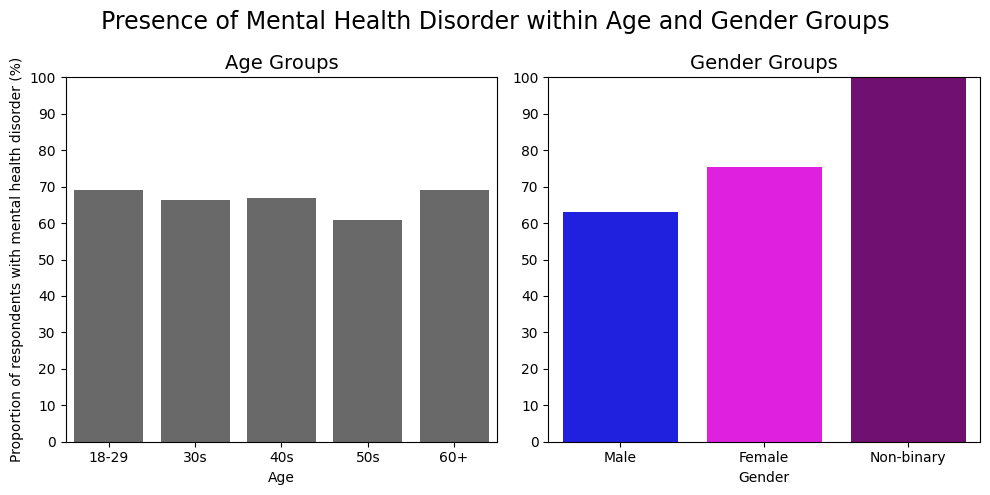

In [316]:
mhd_mhs_diff_MHD = mhd_mhs_diff[["age", "gender", "mhd"]].dropna()

mhd_mhs_diff_MHD_age = (
    mhd_mhs_diff_MHD.sort_values(by="age")
    .groupby("age")["mhd"]
    .value_counts(normalize=True)
    .unstack()
)
mhd_mhs_diff_MHD_age["percentage_yes"] = mhd_mhs_diff_MHD_age["Yes"] * 100

mhd_mhs_diff_MHD_gender = (
    mhd_mhs_diff_MHD.groupby("gender")["mhd"].value_counts(normalize=True).unstack()
)
mhd_mhs_diff_MHD_gender["percentage_yes"] = mhd_mhs_diff_MHD_gender["Yes"] * 100


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(
    "Presence of Mental Health Disorder within Age and Gender Groups", fontsize=17
)

sns.barplot(
    mhd_mhs_diff_MHD_age, x="age", y="percentage_yes", color="dimgrey", ax=axes[0]
)
sns.barplot(
    mhd_mhs_diff_MHD_gender,
    x="gender",
    y="percentage_yes",
    hue="gender",
    order=["Male", "Female", "Non-binary"],
    hue_order=["Male", "Female", "Non-binary"],
    palette=sns.color_palette(["blue", "magenta", "purple"]),
    ax=axes[1],
)

axes[0].set_title("Age Groups", fontsize=14)
axes[0].set_ylabel("Proportion of respondents with mental health disorder (%)")
axes[0].set_ylim(0, 100)
axes[0].yaxis.set_major_locator(MultipleLocator(10))
axes[0].set_xlabel("Age")

axes[1].set_title("Gender Groups", fontsize=14)
axes[1].set_ylabel("")
axes[1].set_ylim(0, 100)
axes[1].yaxis.set_major_locator(MultipleLocator(10))
axes[1].set_xlabel("Gender")

plt.tight_layout()

* **No relevant differences observed between the different age groups regarding the presence of a mental health disorder.**

    >This shows us that mental issues can be equally likely present in every person no matter their age.

&nbsp;

* **Remarkably, all non-binary people had a mental disorder, while females had an approximate 75% prevalence and males 62%.**

    >Among gender groups, non-binary people are the ones who may require more support and treatment for mental conditions, followed by females.

&nbsp;

### 3.3. Mental Health Resources
*Do employers provide resources to learn more about mental health issues and how to seek help? Are employees aware of them?* 

*Are employers to people in a certain age or gender group more prone to offer resources about mental health than employers to people in the other age or gender groups?*

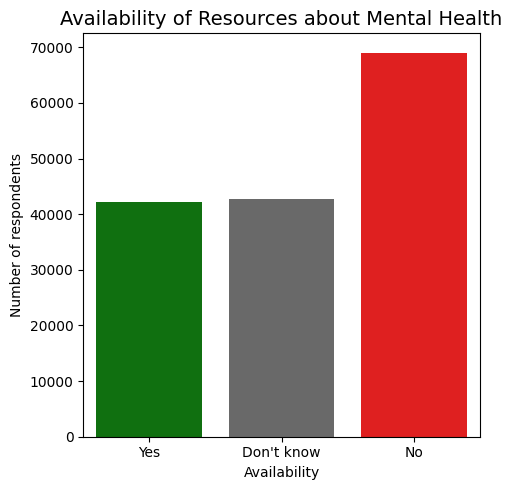

In [317]:
mhd_mhs_diff_RESOURCES = mhd_mhs_diff[["age", "gender", "resources"]].dropna()


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.countplot(
    mhd_mhs_diff_RESOURCES,
    x="resources",
    hue="resources",
    palette=["green", "dimgrey", "red"],
)

ax.set_title("Availability of Resources about Mental Health", fontsize=14)
ax.set_ylabel("Number of respondents")
ax.set_xlabel("Availability")

plt.tight_layout()

* **The majority of people states that they either don't have any mental health resources for learning and seeking help, or simply don't even know about them.**

    >It is very necessary for employers to make these resources available and known to their employees.

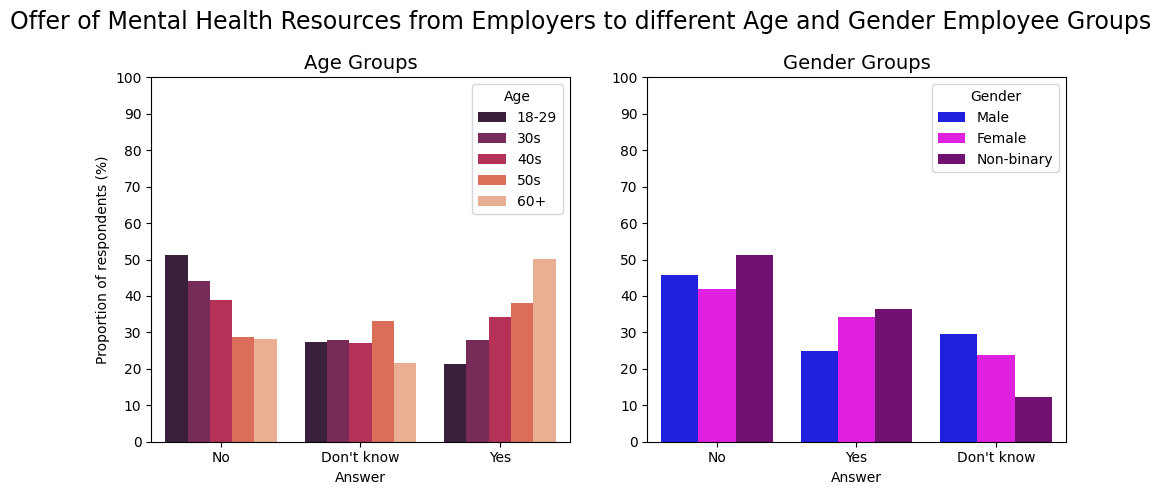

In [318]:
mhd_mhs_diff_RESOURCES_age = (
    mhd_mhs_diff_RESOURCES.sort_values(by="age")
    .groupby("age")["resources"]
    .value_counts(normalize=True)
    .reset_index()
)
mhd_mhs_diff_RESOURCES_age.columns = ["age", "resources", "proportion"]
mhd_mhs_diff_RESOURCES_age["proportion"] *= 100

mhd_mhs_diff_RESOURCES_gender = (
    mhd_mhs_diff_RESOURCES.groupby("gender")["resources"]
    .value_counts(normalize=True)
    .reset_index()
)
mhd_mhs_diff_RESOURCES_gender.columns = ["gender", "resources", "proportion"]
mhd_mhs_diff_RESOURCES_gender["proportion"] *= 100


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(
    "Offer of Mental Health Resources from Employers to different Age and Gender Employee Groups",
    fontsize=17,
)

sns.barplot(
    mhd_mhs_diff_RESOURCES_age,
    x="resources",
    y="proportion",
    hue="age",
    palette="rocket",
    ax=axes[0],
)
sns.barplot(
    mhd_mhs_diff_RESOURCES_gender,
    x="resources",
    y="proportion",
    hue="gender",
    hue_order=["Male", "Female", "Non-binary"],
    palette=sns.color_palette(["blue", "magenta", "purple"]),
    ax=axes[1],
)

axes[0].set_title("Age Groups", fontsize=14)
axes[0].set_ylabel("Proportion of respondents (%)")
axes[0].set_ylim(0, 100)
axes[0].yaxis.set_major_locator(MultipleLocator(10))
axes[0].set_xlabel("Answer")
axes[0].legend(title="Age")

axes[1].set_title("Gender Groups", fontsize=14)
axes[1].set_ylabel("")
axes[1].set_ylim(0, 100)
axes[1].yaxis.set_major_locator(MultipleLocator(10))
axes[1].set_xlabel("Answer")
axes[1].legend(title="Gender")

plt.tight_layout(w_pad=3)

* **Employers whose employees were younger tended to not make available mental health resources, but older employees had more often employers who did.**

    >Could this be explained by a belief that younger people are more educated on the matter, and so do not need as much mental health resources for learning?

&nbsp;

* **Males tended slighly more to not know about the existence of mental health resources.**

&nbsp;

### 3.4. Mental Health Benefits
*Do employers provide mental health benefits as part of healthcare coverage?*

*Does the offer of such benefits vary between different age and gender groups of employees?*

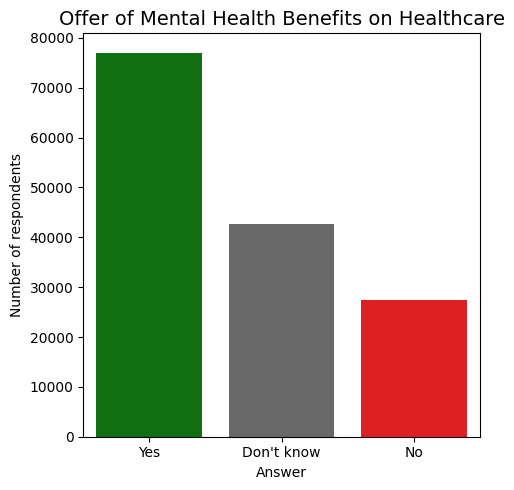

In [319]:
mhd_mhs_diff_BENEFITS = mhd_mhs_diff[["age", "gender", "benefits"]].dropna()


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.countplot(
    mhd_mhs_diff_BENEFITS,
    x="benefits",
    hue="benefits",
    palette=["green", "dimgrey", "red"],
)

ax.set_title("Offer of Mental Health Benefits on Healthcare", fontsize=14)
ax.set_ylabel("Number of respondents")
ax.set_xlabel("Answer")

plt.tight_layout()

* **Slightly below half the participants did not know or did not actually have mental health benefits on healthcare.**

    >It is necessary for more employers to cover for mental health benefits, and let their employees know about them through, for instance, mental health information or awareness sessions.

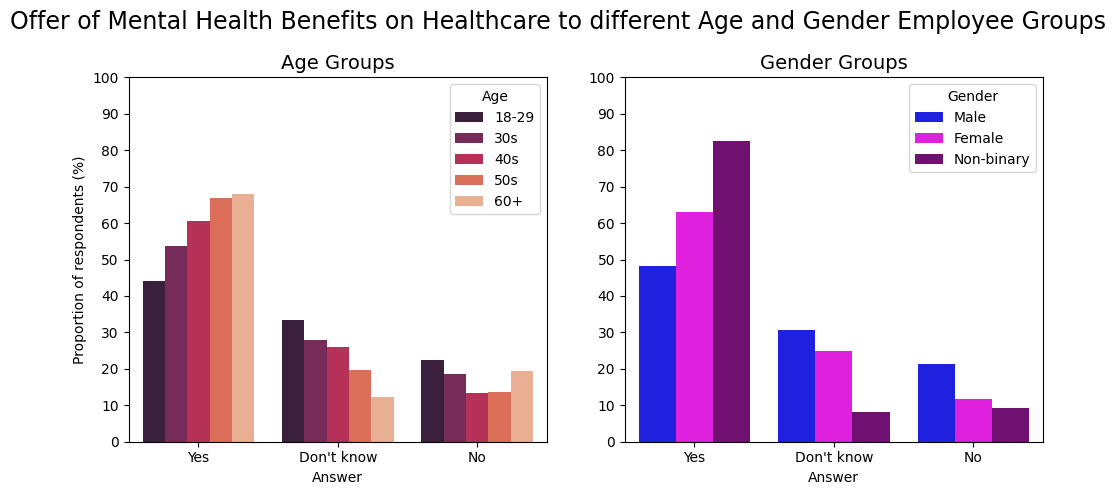

In [320]:
mhd_mhs_diff_BENEFITS_age = (
    mhd_mhs_diff_BENEFITS.sort_values(by="age")
    .groupby("age")["benefits"]
    .value_counts(normalize=True)
    .reset_index()
)
mhd_mhs_diff_BENEFITS_age.columns = ["age", "benefits", "proportion"]
mhd_mhs_diff_BENEFITS_age["proportion"] *= 100

mhd_mhs_diff_BENEFITS_gender = (
    mhd_mhs_diff_BENEFITS.groupby("gender")["benefits"]
    .value_counts(normalize=True)
    .reset_index()
)
mhd_mhs_diff_BENEFITS_gender.columns = ["gender", "benefits", "proportion"]
mhd_mhs_diff_BENEFITS_gender["proportion"] *= 100


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(
    "Offer of Mental Health Benefits on Healthcare to different Age and Gender Employee Groups",
    fontsize=17,
)

sns.barplot(
    mhd_mhs_diff_BENEFITS_age,
    x="benefits",
    y="proportion",
    hue="age",
    palette="rocket",
    ax=axes[0],
)
sns.barplot(
    mhd_mhs_diff_BENEFITS_gender,
    x="benefits",
    y="proportion",
    hue="gender",
    hue_order=["Male", "Female", "Non-binary"],
    palette=sns.color_palette(["blue", "magenta", "purple"]),
    ax=axes[1],
)

axes[0].set_title("Age Groups", fontsize=14)
axes[0].set_ylabel("Proportion of respondents (%)")
axes[0].set_ylim(0, 100)
axes[0].yaxis.set_major_locator(MultipleLocator(10))
axes[0].set_xlabel("Answer")
axes[0].legend(title="Age")

axes[1].set_title("Gender Groups", fontsize=14)
axes[1].set_ylabel("")
axes[1].set_ylim(0, 100)
axes[1].yaxis.set_major_locator(MultipleLocator(10))
axes[1].set_xlabel("Answer")
axes[1].legend(title="Gender")

plt.tight_layout(w_pad=3)

* **Employers whose employees were older tended more to offer mental health benefits on healthcare, but younger employees more often did not even know whether they had them.**

    >Once again, the need for information/awareness sessions on mental health.

&nbsp;

* **Males more often did not have or did not know whether they had mental health benefits.**

&nbsp;

### 3.5. Talking about Mental Health Issues with Supervisor(s)
*How willing/comfortable are employees to talk about mental health issues with their direct supervisor(s)?*

*Does that willingness/comfort change according to age or gender?*

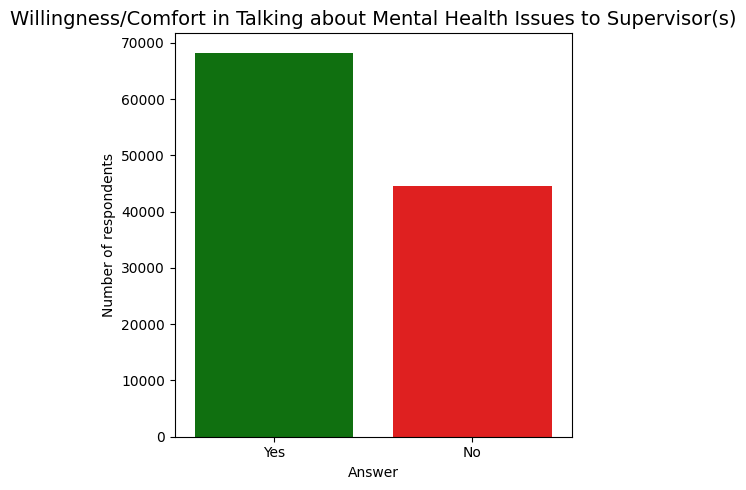

In [321]:
mhd_mhs_diff_COMFORT = mhd_mhs_diff[["age", "gender", "comfort"]].dropna()


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.countplot(
    mhd_mhs_diff_COMFORT, x="comfort", hue="comfort", palette=["green", "red"]
)

ax.set_title(
    "Willingness/Comfort in Talking about Mental Health Issues to Supervisor(s)",
    fontsize=14,
)
ax.set_ylabel("Number of respondents")
ax.set_xlabel("Answer")

plt.tight_layout()

* **The larger portion of participants did feel comfortable enough to talk to supervisors about mental health, but there was still a very considerable number of people who did not.**

    >There is the need for supervisors and people in higher positions in general to make themselves more approachable and open to freely discuss mental issues. Such finding could also be due to these people not being themselves comfortable enough to take such matters at hand, and therefore training/tutoring sessions for them could eventually prove to be fruitful.

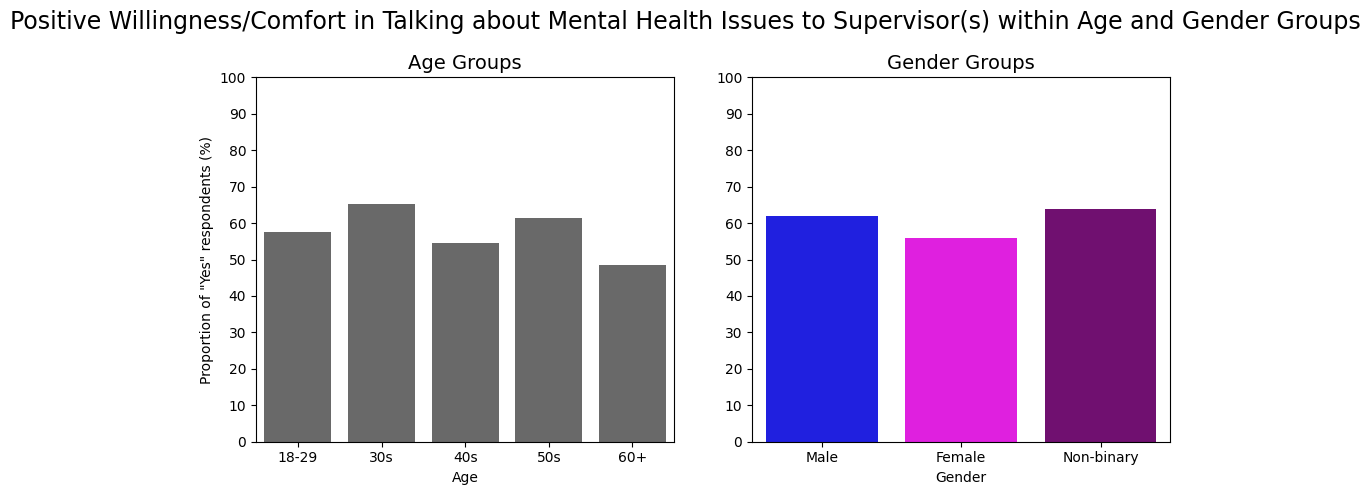

In [322]:
mhd_mhs_diff_COMFORT_age = (
    mhd_mhs_diff_COMFORT.sort_values(by="age")
    .groupby("age")["comfort"]
    .value_counts(normalize=True)
    .unstack()
)
mhd_mhs_diff_COMFORT_age["percentage_yes"] = mhd_mhs_diff_COMFORT_age["Yes"] * 100

mhd_mhs_diff_COMFORT_gender = (
    mhd_mhs_diff_COMFORT.groupby("gender")["comfort"]
    .value_counts(normalize=True)
    .unstack()
)
mhd_mhs_diff_COMFORT_gender["percentage_yes"] = mhd_mhs_diff_COMFORT_gender["Yes"] * 100


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(
    "Positive Willingness/Comfort in Talking about Mental Health Issues to Supervisor(s) within Age and Gender Groups",
    fontsize=17,
)

sns.barplot(
    mhd_mhs_diff_COMFORT_age, x="age", y="percentage_yes", color="dimgrey", ax=axes[0]
)
sns.barplot(
    mhd_mhs_diff_COMFORT_gender,
    x="gender",
    y="percentage_yes",
    hue="gender",
    order=["Male", "Female", "Non-binary"],
    hue_order=["Male", "Female", "Non-binary"],
    palette=sns.color_palette(["blue", "magenta", "purple"]),
    ax=axes[1],
)

axes[0].set_title("Age Groups", fontsize=14)
axes[0].set_ylabel('Proportion of "Yes" respondents (%)')
axes[0].set_ylim(0, 100)
axes[0].yaxis.set_major_locator(MultipleLocator(10))
axes[0].set_xlabel("Age")

axes[1].set_title("Gender Groups", fontsize=14)
axes[1].set_ylabel("")
axes[1].set_ylim(0, 100)
axes[1].yaxis.set_major_locator(MultipleLocator(10))
axes[1].set_xlabel("Gender")

plt.tight_layout(w_pad=3)

* **No relevant differences found regarding willingness to talk about mental issues to supervisors within age or gender groups.**

&ensp;&ensp;&ensp;&ensp;***Note**: For this chapter, I have decided to not include the questions regarding speaking to an employer as this one may be from a very large company and not be close at all to some employees. Therefore, a direct supervisor would always be closer to the employees, facilitating the communication.*

&nbsp;

### 3.6. Unsupportive Attitudes towards Mental Health Issues
*Is it common to have observed or experienced an unsupportive or badly handled response to a mental health issue?*

*Do different age or gender groups observe or experience them at different frequencies?*

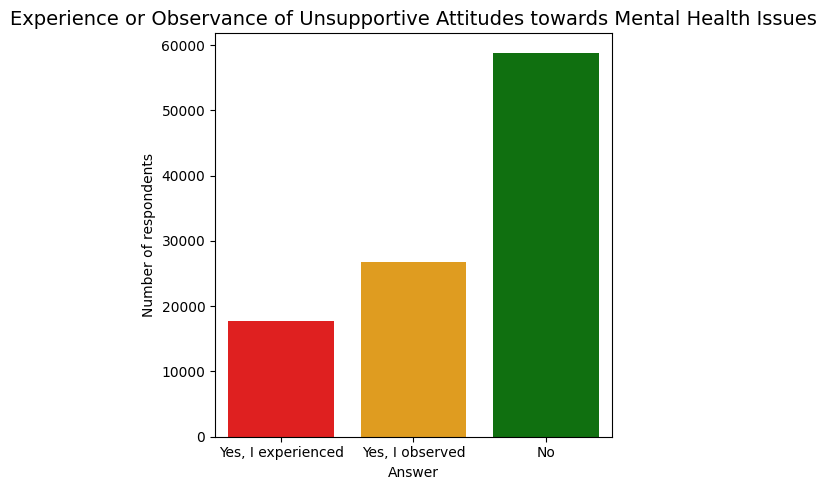

In [323]:
mhd_mhs_diff_BADSUPP = mhd_mhs_diff[["age", "gender", "bad_supp"]].dropna()


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.countplot(
    mhd_mhs_diff_BADSUPP,
    x="bad_supp",
    hue="bad_supp",
    order=["Yes, I experienced", "Yes, I observed", "No"],
    hue_order=["Yes, I experienced", "Yes, I observed", "No"],
    palette=["red", "orange", "green"],
)

ax.set_title(
    "Experience or Observance of Unsupportive Attitudes towards Mental Health Issues",
    fontsize=14,
)
ax.set_ylabel("Number of respondents")
ax.set_xlabel("Answer")

plt.tight_layout()

* **More than half the participants did not observe/experience unsupportive attitudes. However, a still very considerable number of them did either experience or observe.**

    >It would be important for resources and awareness sessions to be available at the workplace, so as to make it healthier and more sustainable.

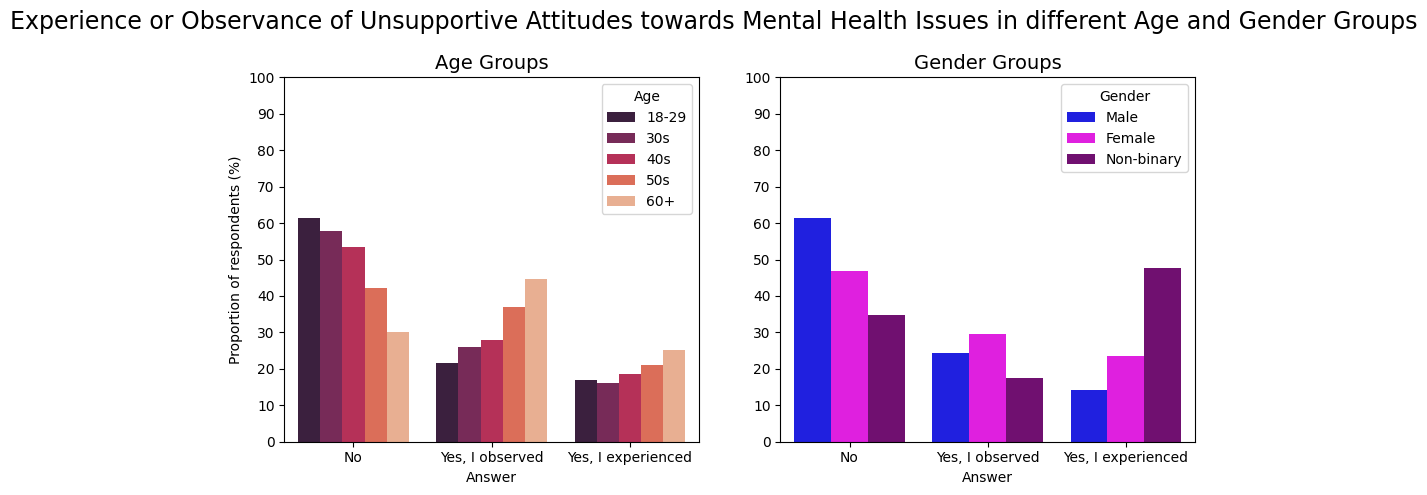

In [324]:
mhd_mhs_diff_BADSUPP_age = (
    mhd_mhs_diff_BADSUPP.sort_values(by="age")
    .groupby("age")["bad_supp"]
    .value_counts(normalize=True)
    .reset_index()
)
mhd_mhs_diff_BADSUPP_age.columns = ["age", "bad_supp", "proportion"]
mhd_mhs_diff_BADSUPP_age["proportion"] *= 100

mhd_mhs_diff_BADSUPP_gender = (
    mhd_mhs_diff_BADSUPP.groupby("gender")["bad_supp"]
    .value_counts(normalize=True)
    .reset_index()
)
mhd_mhs_diff_BADSUPP_gender.columns = ["gender", "bad_supp", "proportion"]
mhd_mhs_diff_BADSUPP_gender["proportion"] *= 100


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(
    "Experience or Observance of Unsupportive Attitudes towards Mental Health Issues in different Age and Gender Groups",
    fontsize=17,
)

sns.barplot(
    mhd_mhs_diff_BADSUPP_age,
    x="bad_supp",
    y="proportion",
    hue="age",
    palette="rocket",
    ax=axes[0],
)
sns.barplot(
    mhd_mhs_diff_BADSUPP_gender,
    x="bad_supp",
    y="proportion",
    hue="gender",
    hue_order=["Male", "Female", "Non-binary"],
    palette=sns.color_palette(["blue", "magenta", "purple"]),
    ax=axes[1],
)

axes[0].set_title("Age Groups", fontsize=14)
axes[0].set_ylabel("Proportion of respondents (%)")
axes[0].set_ylim(0, 100)
axes[0].yaxis.set_major_locator(MultipleLocator(10))
axes[0].set_xlabel("Answer")
axes[0].legend(title="Age")

axes[1].set_title("Gender Groups", fontsize=14)
axes[1].set_ylabel("")
axes[1].set_ylim(0, 100)
axes[1].yaxis.set_major_locator(MultipleLocator(10))
axes[1].set_xlabel("Answer")
axes[1].legend(title="Gender")

plt.tight_layout(w_pad=3)

* **Older employees were the ones who most often had already observed/experienced unsupportive attitudes.**

    >Such finding could be due to the fact that these people had more life/work experience, hence accumulating more chances of having witnessed/experienced such event.

&nbsp;

* **Non-binary people were the ones who more often had experienced unsupportive attitudes. Men most often did not.**

    >This could be perhaps explained by some discrimination associated with their non-gender identity. However, the number of non-binary people in our sample is really small, so the robustness of our findings regarding this group can be compromised.

    >Regarding men, the finding could partially be explained by their lower mental health prevalence, making them less susceptible to experience unsupportive attitudes towards mental issues.

&nbsp;

### 3.7. Supportive Attitudes towards Mental Health Issues
*Is it common to have observed or experienced a supportive or well handled response to a mental health issue?*

*Do different age or gender groups observe or experience them at different frequencies?*

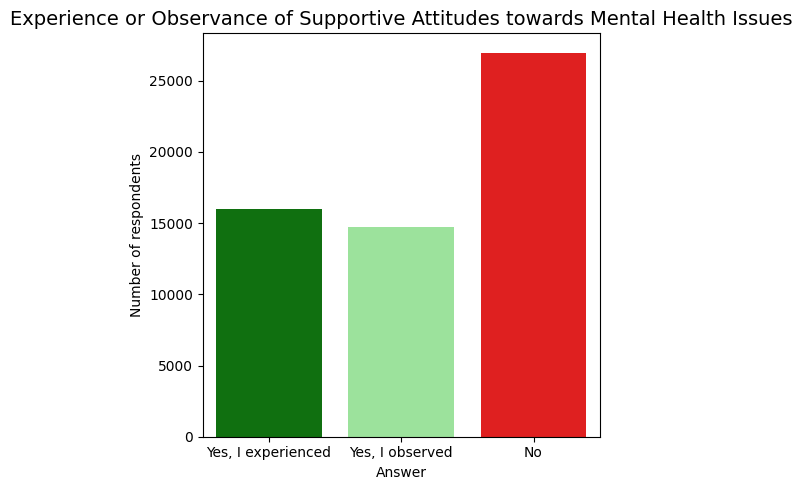

In [325]:
mhd_mhs_diff_GOODSUPP = mhd_mhs_diff[["age", "gender", "good_supp"]].dropna()


fig, ax = plt.subplots(1, 1, figsize=(5, 5))

sns.countplot(
    mhd_mhs_diff_GOODSUPP,
    x="good_supp",
    hue="good_supp",
    order=["Yes, I experienced", "Yes, I observed", "No"],
    hue_order=["Yes, I experienced", "Yes, I observed", "No"],
    palette=["green", "lightgreen", "red"],
)

ax.set_title(
    "Experience or Observance of Supportive Attitudes towards Mental Health Issues",
    fontsize=14,
)
ax.set_ylabel("Number of respondents")
ax.set_xlabel("Answer")

plt.tight_layout()

* **Slightly more than half the participants have experienced/observed supportive attitudes.**

    >While this can be a good result, it would be wonderful to see more people witnessing/experiencing such attitudes. Therefore, it should be cultivated in the workplace an environment of companionship and support.

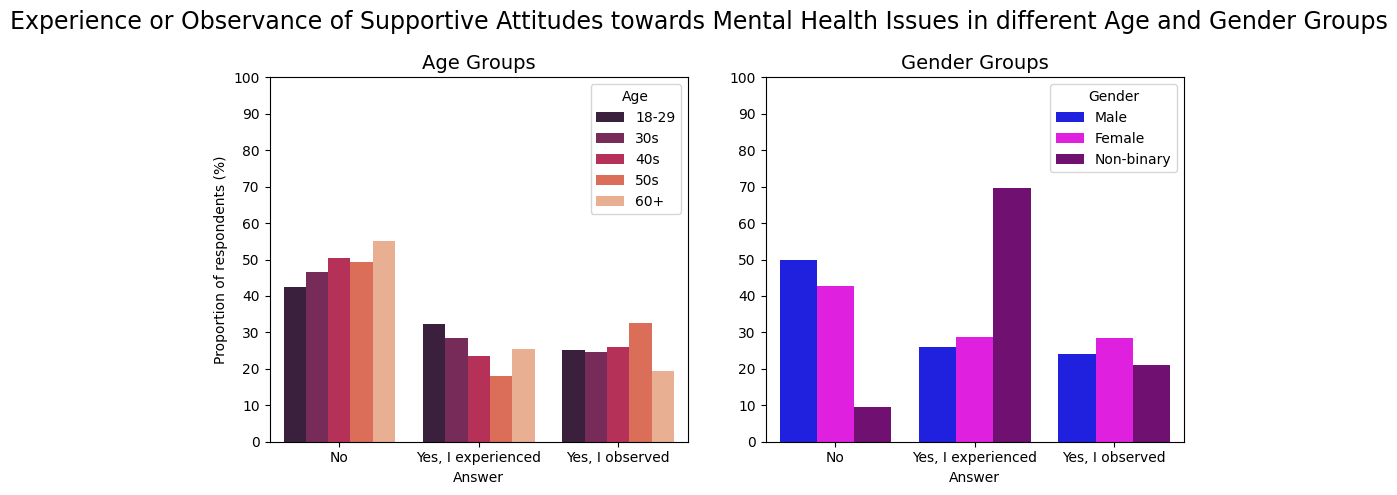

In [326]:
mhd_mhs_diff_GOODSUPP_age = (
    mhd_mhs_diff_GOODSUPP.sort_values(by="age")
    .groupby("age")["good_supp"]
    .value_counts(normalize=True)
    .reset_index()
)
mhd_mhs_diff_GOODSUPP_age.columns = ["age", "good_supp", "proportion"]
mhd_mhs_diff_GOODSUPP_age["proportion"] *= 100

mhd_mhs_diff_GOODSUPP_gender = (
    mhd_mhs_diff_GOODSUPP.groupby("gender")["good_supp"]
    .value_counts(normalize=True)
    .reset_index()
)
mhd_mhs_diff_GOODSUPP_gender.columns = ["gender", "good_supp", "proportion"]
mhd_mhs_diff_GOODSUPP_gender["proportion"] *= 100


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(
    "Experience or Observance of Supportive Attitudes towards Mental Health Issues in different Age and Gender Groups",
    fontsize=17,
)

sns.barplot(
    mhd_mhs_diff_GOODSUPP_age,
    x="good_supp",
    y="proportion",
    hue="age",
    palette="rocket",
    ax=axes[0],
)
sns.barplot(
    mhd_mhs_diff_GOODSUPP_gender,
    x="good_supp",
    y="proportion",
    hue="gender",
    hue_order=["Male", "Female", "Non-binary"],
    palette=sns.color_palette(["blue", "magenta", "purple"]),
    ax=axes[1],
)

axes[0].set_title("Age Groups", fontsize=14)
axes[0].set_ylabel("Proportion of respondents (%)")
axes[0].set_ylim(0, 100)
axes[0].yaxis.set_major_locator(MultipleLocator(10))
axes[0].set_xlabel("Answer")
axes[0].legend(title="Age")

axes[1].set_title("Gender Groups", fontsize=14)
axes[1].set_ylabel("")
axes[1].set_ylim(0, 100)
axes[1].yaxis.set_major_locator(MultipleLocator(10))
axes[1].set_xlabel("Answer")
axes[1].legend(title="Gender")

plt.tight_layout(w_pad=3)

cur.close()
con.close()

* **There was not much of a difference regarding supportive attitudes in the age groups.**

&nbsp;

* **Non-binary people were the ones who more often had experienced supportive attitudes.**

    >Such finding comes in contrast with the previous one, where we found that non-binary had more often experienced unsupportive attitudes. Hence, it seems this group is more vulnerable to experience any kind of attitudes towards it. One could point out the fact that they had the highest prevalence of mental health disorders (100%), making them more susceptible to such experiences. On the other hand, due to their possibly associated degree of discrimination, they can also get both supportive (for overcoming the discrimination) and unsupportive (the discrimination itself) attitudes.
    
    >Either way, it comes to show that this group needs to be especially protected and supported.

&nbsp;

## 4. Conclusions / Key Takeaways
* **There is a large prevalence of mental health disorders in the tech industry.**

&nbsp;

* **The most common mental health problems were mood and anxiety disorders, and an individual may have more than one disorder at the same time.**

&nbsp;

* **More than half of the individuals with mental problems stated that their productivity is affected during more than 25% of their worktime.**

&nbsp;

* **Non-binary people are the ones who need the most support and treatment.**

&nbsp;

* **It is necessary for employers to make mental health resources for learning and seeking help available and known to their employees.**

    >Here, employers whose employees were younger tended to not make available mental health resources, but older employees had more often employers who did.

&nbsp;

* **It is necessary for more employers to cover for mental health benefits, and let their employees know about them through, for instance, mental health information or awareness sessions.**

&nbsp;

* **There is the need for supervisors and people in higher positions in general to make themselves more approachable and open to freely discuss mental issues. Training/tutoring sessions for them on how to deal with mental issues could eventually prove to be fruitful as well.**

&nbsp;

* **It should be created in the workplace an environment/culture of companionship and support, so as to decrease the unsupportive attitudes towards mental issues, and increase the supportive ones.**

    >Such could be achieved through sessions/workshops on how to handle with mental issues.

&nbsp;

## 5. Suggestions for Analysis Improvement
When handling missing data, the option to impute data in those questions whose answers had less than 5% of missing data could have been undertaken.

Regarding the gender question, since there were too many different types of answers, one could have taken more of them into consideration and group them into the appropriate groups.

Additionally, there was a low number of non-binary and older people, which could have hindered the findings on these groups.

Finally, since this database had in total 105 questions, many different types of analyses could have been undertaken. As suggestions for further analyses, one could look for instance at the remote/hybrid/presential work employees, or work positions, and compare them in terms of mental health diagnoses, or mental health support. Another suggestion could be to look into what individuals in the surveys believe would improve mental health support in their companies. For that, a library called wordcloud could be put to good use.